<a href="https://colab.research.google.com/github/Praneeth-18/Deep-Learning-7/blob/main/Part_2_%26_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 2 - Transfer learning on various modalities :**
Write simple colabs to transfer learn on images, videos, audios -  - with both as a feature extractor as well as a fine tuning usecases **bold text

# **Audio**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np


In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
# Generating mock data
num_samples = 1000
embeddings = np.random.normal(loc=0.0, scale=1.0, size=(num_samples, 1024))
labels = np.random.randint(0, 2, size=(num_samples,))
folds = np.random.randint(1, 6, size=(num_samples,))

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((embeddings, labels, folds))


In [ ]:
def filter_by_fold(emb, label, fold, fold_number):
    return fold == fold_number

train = dataset.filter(lambda emb, label, fold: fold < 4)
val = dataset.filter(lambda emb, label, fold: fold == 4)
test = dataset.filter(lambda emb, label, fold: fold == 5)


In [ ]:
my_classes = ['Cat', 'Dog']  # Assuming 0 for 'Cat', 1 for 'Dog'
classifier = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes), activation='softmax')
])
classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


In [ ]:
classifier.fit(train.batch(32), epochs=10, validation_data=val.batch(32))


Epoch 1/10
     19/Unknown - 1s 16ms/step - loss: 2.0193 - accuracy: 0.4897

19/19 [==============================] - 1s 38ms/step - loss: 2.0193 - accuracy: 0.4897 - val_loss: 4.2375 - val_accuracy: 0.4861
Epoch 2/10
16/19 [========================>.....] - ETA: 0s - loss: 0.1794 - accuracy: 0.9512

19/19 [==============================] - 0s 25ms/step - loss: 0.1784 - accuracy: 0.9502 - val_loss: 4.7602 - val_accuracy: 0.4907
Epoch 3/10
18/19 [===========================>..] - ETA: 0s - loss: 0.0514 - accuracy: 0.9983

19/19 [==============================] - 0s 22ms/step - loss: 0.0509 - accuracy: 0.9983 - val_loss: 4.8204 - val_accuracy: 0.5093
Epoch 4/10
17/19 [=========================>....] - ETA: 0s - loss: 0.0268 - accuracy: 1.0000

19/19 [==============================] - 0s 13ms/step - loss: 0.0260 - accuracy: 1.0000 - val_loss: 4.9142 - val_accuracy: 0.5093
Epoch 5/10
18/19 [===========================>..] - ETA: 0s - loss: 0.0182 - accuracy: 1.0000

19/19 [==============================] - 0s 14ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 4.9806 - val_accuracy: 0.4954
Epoch 6/10
18/19 [===========================>..] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000

19/19 [==============================] - 0s 15ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 5.0328 - val_accuracy: 0.4907
Epoch 7/10
17/19 [=========================>....] - ETA: 0s - loss: 0.0117 - accuracy: 1.0000

19/19 [==============================] - 0s 14ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 5.0809 - val_accuracy: 0.4907
Epoch 8/10
19/19 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000

19/19 [==============================] - 0s 14ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 5.1272 - val_accuracy: 0.4907
Epoch 9/10
17/19 [=========================>....] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000

19/19 [==============================] - 0s 15ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 5.1717 - val_accuracy: 0.5000
Epoch 10/10
13/19 [===================>..........] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000

19/19 [==============================] - 0s 13ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 5.2141 - val_accuracy: 0.4954


In [ ]:
test_results = classifier.evaluate(test.batch(32))
print("Test Loss, Test Accuracy:", test_results)


7/7 [==============================] - 0s 9ms/step - loss: 8.0797 - accuracy: 0.4257
Test Loss, Test Accuracy: [8.079726219177246, 0.42574256658554077]


In [ ]:
def predict_audio_class(audio_data, model, classes):
    # Ensure audio_data is a 1D float32 tensor
    if len(audio_data.shape) > 1 or audio_data.dtype != tf.float32:
        audio_data = tf.reshape(audio_data, [-1])  # Flatten the array if not already
        audio_data = tf.cast(audio_data, tf.float32)  # Cast to float32

    # Pass the audio data through YAMNet
    scores, embeddings, spectrogram = model(audio_data)

    # Assuming the classifier is defined elsewhere and properly trained
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])

    # Since YAMNet returns multiple embeddings for a single waveform, average them
    averaged_embeddings = tf.reduce_mean(embeddings, axis=0, keepdims=True)

    # Run prediction
    predictions = classifier(averaged_embeddings)
    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
    predicted_class = classes[predicted_class_index]

    return predicted_class

In [ ]:
test_audio = np.random.normal(size=(16000,)).astype(np.float32)
test_audio_tensor = tf.convert_to_tensor(test_audio, dtype=tf.float32)

In [ ]:
my_classes = ['Cat', 'Dog']
predicted_class = predict_audio_class(test_audio_tensor, yamnet_model, my_classes)
print("Predicted Class:", predicted_class)

Predicted Class: Cat


# **Video**

In [ ]:
# Install necessary libraries
!pip install -q imageio
!pip install -q opencv-python-headless  # Use headless OpenCV to avoid GUI conflicts in environments without display capabilities
!pip install -q tensorflow tensorflow-hub

import imageio
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from urllib.request import urlretrieve
from IPython.display import HTML
from base64 import b64encode

# Define a function to download and load a video
def fetch_video(url):
    video_path = 'sample_video.mp4'
    urlretrieve(url, video_path)
    return video_path

def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
        frames.append(frame)
        if len(frames) == max_frames:
            break
    cap.release()
    return np.array(frames) / 255.0

def to_gif(images):
    # Ensure images are scaled to 0-255 and are of type uint8
    images = (images * 255).astype(np.uint8)  # Assuming the input is scaled between 0 and 1
    imageio.mimsave('animation.gif', images, fps=10)
    return 'animation.gif'

# Load the I3D model from TensorFlow Hub
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

def predict(model, video_array):
    model_input = tf.constant(video_array, dtype=tf.float32)[tf.newaxis, ...]
    logits = model(model_input)['default'][0]
    probabilities = tf.nn.softmax(logits)
    return probabilities

# Download Kinetics-400 labels
labels_url = 'https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt'
labels_path = 'kinetics_label_map.txt'
urlretrieve(labels_url, labels_path)

with open(labels_path) as f:
    labels = [line.strip() for line in f.readlines()]

# Main execution: Download video, process, predict, and display results
video_url = "https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv"
video_path = fetch_video(video_url)
video_array = load_video(video_path, max_frames=250)

# Make predictions
probabilities = predict(i3d, video_array)

# Get the top 5 actions
top5 = np.argsort(probabilities)[::-1][:5]
print("Top 5 Actions:")
for i in top5:
    print(f"{labels[i]}: {probabilities[i] * 100:.2f}%")

# Convert part of the video to GIF for visualization
gif_path = to_gif(video_array[:100])

# Display the GIF in the notebook
mp4 = open(gif_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Top 5 Actions:
playing basketball: 32.44%
shooting basketball: 24.61%
dunking basketball: 13.92%
roller skating: 8.58%
playing volleyball: 7.01%


# **Image**

In [34]:
# Install required packages
!pip install -q tensorflow

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Data preparation
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Configure dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = validation_dataset.take(20)  # Use 20 batches for testing
validation_dataset = validation_dataset.skip(20)

# Create the base model from MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Feature extraction
base_model.trainable = False

# Create a new model on top
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the model
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# Evaluation
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
63/63 [==============================] - 54s 790ms/step - loss: 0.6174 - accuracy: 0.6660 - val_loss: 0.4943 - val_accuracy: 0.7944
Epoch 2/10
63/63 [==============================] - 50s 785ms/step - loss: 0.4191 - accuracy: 0.8180 - val_loss: 0.3610 - val_accuracy: 0.8639
Epoch 3/10
63/63 [==============================] - 41s 650ms/step - loss: 0.3062 - accuracy: 0.8995 - val_loss: 0.2726 - val_accuracy: 0.9139
Epoch 4/10
63/63 [==============================] - 49s 765ms/step - loss: 0.2396 - accuracy: 0.9300 - val_loss: 0.2206 - val_accuracy: 0.9444
Epoch 5/10
63/63 [==============================] - 48s 755ms/step - loss: 0.2058 - accuracy: 0.9480 - val_loss: 0.1891 - val_accuracy: 0.9444
Epoch 6/10
63/63 [==============================] - 45s 710ms/step - loss: 

# **NLP**

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())
print("TensorFlow Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.15.0
Eager execution: True
TensorFlow Hub version: 0.16.1
GPU is NOT AVAILABLE


In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)
train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLTE8F2/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLTE8F2/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLTE8F2/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))
print(train_examples[:10])  # Print the first 10 reviews
print(train_labels[:10])    # Print the corresponding labels

Training entries: 25000, test entries: 25000
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because

In [ ]:
embedding_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding_model, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
              metrics=['accuracy'])


In [ ]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]
y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


In [ ]:
history = model.fit(partial_x_train, partial_y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/5
30/30 [==============================] - 47s 2s/step - loss: 0.5393 - accuracy: 0.8043 - val_loss: 0.5025 - val_accuracy: 0.7994
Epoch 2/5
30/30 [==============================] - 46s 2s/step - loss: 0.4132 - accuracy: 0.8605 - val_loss: 0.4069 - val_accuracy: 0.8368
Epoch 3/5
30/30 [==============================] - 46s 2s/step - loss: 0.2981 - accuracy: 0.8989 - val_loss: 0.3436 - val_accuracy: 0.8583
Epoch 4/5
30/30 [==============================] - 46s 2s/step - loss: 0.2167 - accuracy: 0.9289 - val_loss: 0.3172 - val_accuracy: 0.8669
Epoch 5/5
30/30 [==============================] - 47s 2s/step - loss: 0.1571 - accuracy: 0.9529 - val_loss: 0.3046 - val_accuracy: 0.8762


In [ ]:
results = model.evaluate(test_examples, test_labels)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

782/782 [==============================] - 146s 187ms/step - loss: 0.3189 - accuracy: 0.8613
Test Loss: 0.318925142288208, Test Accuracy: 0.8613200187683105


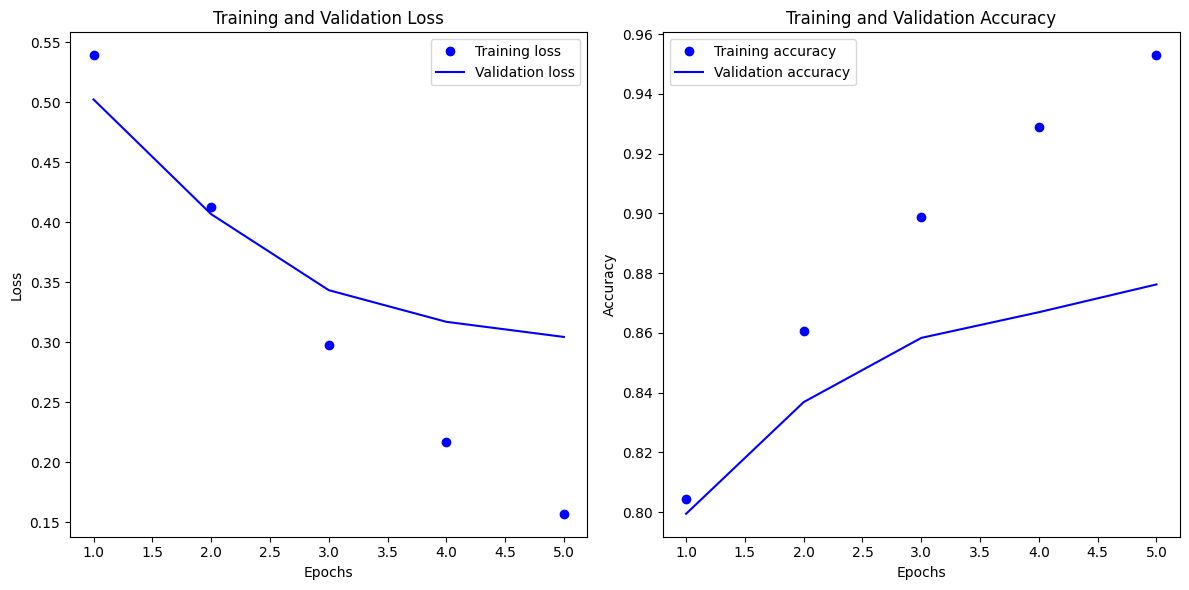

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **Part 3 - Zero shot transfer learning in colab**

# Showcase zero shot transfer learning with CLIP model


In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Image 1: https://upload.wikimedia.org/wikipedia/commons/9/9a/Pug_600.jpg


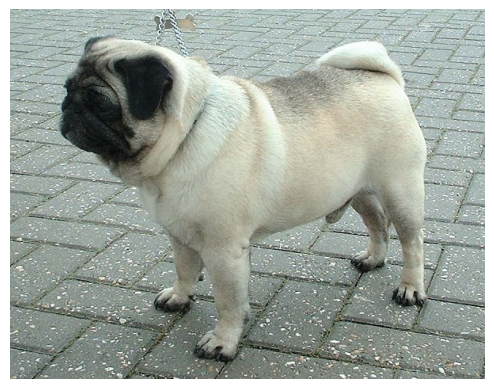

[49406, 320, 1125, 539, 320, 1929, 49407, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] : 1.00
[49406, 320, 1125, 539, 320, 2368, 49407, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] : 0.00
Image 2: https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg


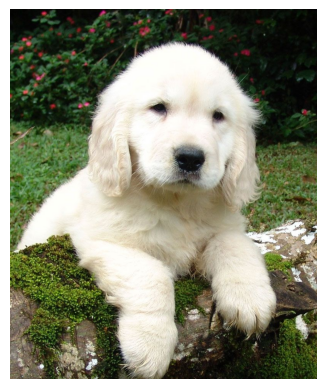

[49406, 320, 1125, 539, 320, 1929, 49407, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] : 1.00
[49406, 320, 1125, 539, 320, 2368, 49407, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] : 0.00


In [45]:
import requests
from PIL import Image
from io import BytesIO
import torch
import clip
import matplotlib.pyplot as plt

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)

# Define a function to download and preprocess the image with User-Agent
def download_image(url):
    headers = {
        "User-Agent": "ExampleBot/0.1 (https://example.com/bot-info)"
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raises a HTTPError for bad responses
        img = Image.open(BytesIO(response.content))
        return preprocess(img).unsqueeze(0).to(device)
    except requests.HTTPError as e:
        print(f"HTTP Error: Could not retrieve image. {e}")
    except requests.RequestException as e:
        print(f"Request failed: {e}")
    except Image.UnidentifiedImageError as e:
        print(f"Cannot identify image file, likely due to its format: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return None

# Sample images with updated URLs or use fallback images
image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/9/9a/Pug_600.jpg",  # Pug (dog)
    "https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg"
]

# Download images and prepare them
image_tensors = [download_image(url) for url in image_urls if download_image(url) is not None]
if image_tensors:
    images = torch.cat(image_tensors)
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(images)
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ["dog", "cat"]]).to(device)
        logits_per_image, logits_per_text = model(images, text_inputs)
        if logits_per_image.numel() > 0:
            probs = logits_per_image.softmax(dim=-1)
            if probs.size(0) >= 5:
                top_probs, top_labels = probs.cpu().topk(5)
            else:
                top_probs, top_labels = probs.cpu().topk(probs.size(0))
        else:
            print("No predictions to process.")

    # Display the results
    for i, (url, top_prob, top_label) in enumerate(zip(image_urls, top_probs, top_labels)):
        print(f"Image {i+1}: {url}")
        try:
            img = Image.open(BytesIO(requests.get(url, headers={"User-Agent": "ExampleBot/0.1"}).content))
            plt.imshow(img)
            plt.axis("off")
            plt.show()
            for prob, label in zip(top_prob, top_label):
                description = text_inputs[label].tolist()
                print(f"{description} : {prob:.2f}")
        except Exception as e:
            print(f"Failed to display image {url}: {e}")
else:
    print("No images were downloaded successfully.")


# Showcase transfer learning using state of art models from tfhub (Eg: use bigtransfer for example) using tfhub

1/1 [==============================] - 1s 1s/step


NotADirectoryError: [Errno 20] Not a directory: '/root/.keras/datasets/flower_photos/roses'

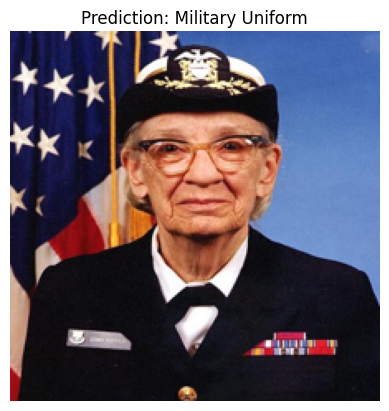

In [47]:
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import datetime
import os

# Load an ImageNet classifier
classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

# Download and display an example image
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper = np.array(grace_hopper) / 255.0

# Predict using the pre-trained model
result = classifier.predict(grace_hopper[np.newaxis, ...])
predicted_class = tf.math.argmax(result[0], axis=-1)

# Decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Simple transfer learning with TensorFlow Hub
# Dataset preparation using TensorFlow Flowers dataset
data_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    extract=True
)

# Correct the data_root path to point directly to the flower_photos folder
data_root = os.path.join(os.path.dirname(data_root), 'flower_photos')

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Configure dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Define the feature extractor
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

# Attach a classification head
num_classes = len(train_ds.class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

# Train the model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

NUM_EPOCHS = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard_callback])

# Start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit

# Export and reload the model
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)
reloaded = tf.keras.models.load_model(export_path)

# Check predictions
for image_batch, labels_batch in train_ds.take(1):
    pass

reloaded_result_batch = reloaded.predict(image_batch)
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = np.array(train_ds.class_names)[reloaded_predicted_id]

# Plot predictions
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n].numpy().astype("uint8"))
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis("off")
_ = plt.suptitle("Model predictions")
